In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from torchdiffeq import odeint  
from diffusers import DDPMScheduler, UNet2DModel
import numpy as np
import os
import pickle

def get_texture_folders(root_dir):
    return [os.path.join(root_dir, texture) for texture in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, texture))]


class TextureDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_pairs = self._load_file_pairs()
    
    def _load_file_pairs(self):
        file_pairs = []
        texture_folders = get_texture_folders(self.root_dir)
        
        for texture_folder in texture_folders:
            texture_name = texture_folder.split("\\")[1]
            
            files = os.listdir(texture_folder)
            base_names = set(f.split(".")[0] for f in files)
            
            for base in base_names:
                image_path = os.path.join(texture_folder, f"{base}.jpg")
                heightmap_path = os.path.join(texture_folder, f"{base}.pkl")
                
                if os.path.exists(image_path) and os.path.exists(heightmap_path):
                    file_pairs.append((image_path, heightmap_path))
        
        return file_pairs
    
    def __len__(self):
        return len(self.file_pairs)
    
    def __getitem__(self, idx):
        image_path, heightmap_path = self.file_pairs[idx]
        image = Image.open(image_path).convert("RGB")
        with open(heightmap_path, 'rb') as f:
            heightmap = pickle.load(f).astype(np.float32)
        
        if self.transform:
            image = self.transform(image)
            heightmap = self.transform(heightmap)
        
        return image, heightmap


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Normalize((0.5,), (0.5,))
])

root_dir = "../Texture"
dataset = TextureDataset(root_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [2]:
model = UNet2DModel(
    sample_size=(240, 320),
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(64, 128, 256, 512),
    down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "UpBlock2D", "UpBlock2D", "UpBlock2D")
)
scheduler = DDPMScheduler(num_train_timesteps=1000)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

for epoch in range(50):
    model.train()
    for image, heightmap in dataloader:
        image, heightmap = image.to(device), heightmap.to(device)
        
        noise = torch.randn_like(heightmap).to(device)
        timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (image.shape[0],), device=device).long()
        noisy_heightmap = scheduler.add_noise(heightmap, noise, timesteps)
        
        pred_noise = model(image, timesteps).sample
        loss = criterion(pred_noise, noise)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
    
torch.save(model.state_dict(), 'DDPM.ckpt')

Epoch 1, Loss: 1.0070
Epoch 2, Loss: 1.0013
Epoch 3, Loss: 1.0021
Epoch 4, Loss: 0.9991
Epoch 5, Loss: 1.0014
Epoch 6, Loss: 1.0029
Epoch 7, Loss: 0.9995
Epoch 8, Loss: 0.9995
Epoch 9, Loss: 1.0011
Epoch 10, Loss: 1.0001
Epoch 11, Loss: 1.0009
Epoch 12, Loss: 0.9987
Epoch 13, Loss: 1.0020
Epoch 14, Loss: 1.0022
Epoch 15, Loss: 1.0002


KeyboardInterrupt: 

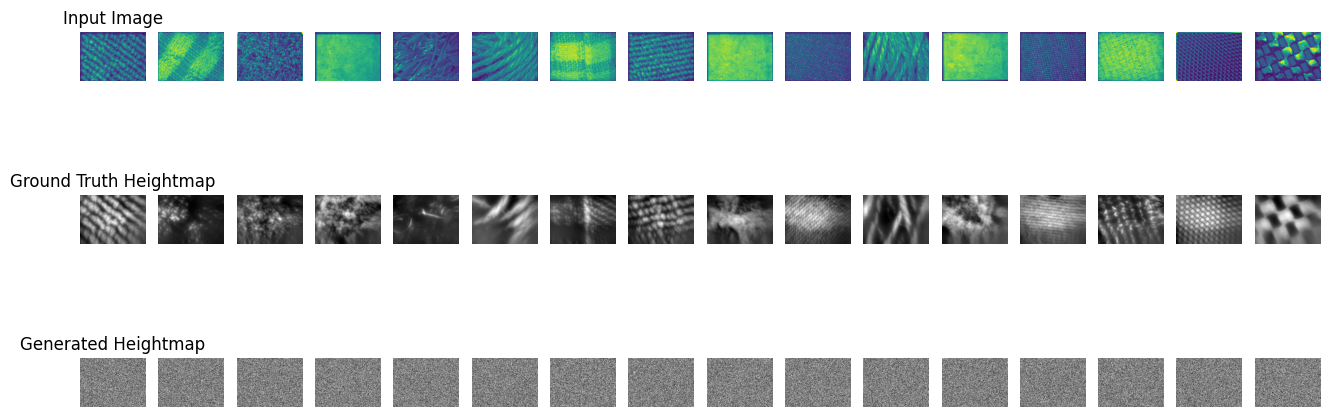

In [6]:
def visualize_results(model, dataloader):
    model.eval()
    with torch.no_grad():
        image, heightmap = next(iter(dataloader))
        image, heightmap = image.to(device), heightmap.to(device)
        
        noisy_sample = torch.randn_like(heightmap).to(device)
        timesteps = torch.tensor([9] * image.shape[0], device=device)
        
        for t in range(9, -1, -1):
            timesteps.fill_(t)
            noisy_sample = scheduler.step(model(image, timesteps).sample, t, noisy_sample).prev_sample
        
    fig, axes = plt.subplots(3, len(image), figsize=(16, 6))
    for i in range(len(image)):
        axes[0, i].imshow(image[i].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
        axes[0, i].axis('off')
        axes[0, 0].set_title("Input Image")

        axes[1, i].imshow(heightmap[i].squeeze().cpu().numpy(), cmap='gray')
        axes[1, i].axis('off')
        axes[1, 0].set_title("Ground Truth Heightmap")
        
        axes[2, i].imshow(noisy_sample[i].squeeze().cpu().numpy(), cmap='gray')
        axes[2, i].axis('off')
        axes[2, 0].set_title("Generated Heightmap")
    
    plt.show()

visualize_results(model, dataloader)